In [90]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, nsolve
from sympy import cosh, sin , sinh, cos,exp
from scipy.special import factorial
from scipy.special import sph_harm_y    #sph_harm_y(l,m,theta,phi)
from scipy.optimize import fsolve
from scipy.integrate import quad,quad_vec
import numba
from decimal import Decimal, getcontext
getcontext().prec = 50  # 设置精度

In [91]:
#System
e2=1.43997 ; hbarc=197.3269718 ; amu=931.49432
zp=69 ; Ap=145 ; mass_excess_p=-27.58 ; mp=Ap*amu+mass_excess_p
z1=68 ; A1=144 ; mass_excess_1=-36.61 ; m1=A1*amu+mass_excess_1    #1-> daughter
z2=1  ; A2=1   ; mass_excess_2=7.288971064 ; m2=A2*amu+mass_excess_2
Q=mp-m1-m2
mu=m1*m2/(m1+m2)

#Potential

#Deformation
beta2 = 0.231  # quadrupole
beta4 = -0.068  # hexadecapole 

#Polarizaton
beta2tilde = 0  
beta4tilde = 0

#spin-orbit
Vso0=6.2 ; rso=1.01*(A1)**(1/3) ; aso=0.75 ; lambda_pi=np.sqrt(2)
L=5; S=0.5; J=5.5

#Vn
a0=0.75 ; r0=1.27*A1**(1/3)-0.1 ; V0=50

#Vc
Rc0 = 1.21 * A1**(1/3)          

#mesh
r = np.linspace(0.03, 30.0, 1000) # avoid too small r
theta_0 = 1e-10                # theta angle (along major axis)


$\frac{\partial}{\partial \theta}Y_{l,m}(\theta,\phi)=\frac{1}{(2l+1)\sin\theta}\left [l(l-m+1)\frac{N_{l,m}}{N_{l+1,m}}Y_{l+1,m}(\theta,\phi)-(l+1)(l+m)\frac{N_{l,m}}{N_{l-1,m}}Y_{l-1,m}(\theta,\phi)]      \right],N_{l,m}=\sqrt{\frac{(2l+1)(l-m)!}{4\pi(l+m)!}}$

$V_{so}=V_{so0}\lambda_\pi^2\frac{1}{r}\frac{d}{dr}\frac{1}{1+\exp[(r-R_{so})/a_{so}]}\vec{\sigma}\cdot\vec{l}=\frac{V_{so0}\lambda_\pi^2}{a_{so}}\times \frac{-e^{\frac{r-R_{so}}{a_{so}}}}{r(1+e^{\frac{r-R_{so}}{a_{so}}})^2}\times\frac{J(J+1)-L(L+1)-S(S+1)}{2}\times2$


Piecewise $K_{\lambda}(r,\theta,\phi)$ with $m=0$ and deformed Coulomb


In [92]:
Nlm=lambda l,m: np.sqrt((2*l+1)/(4*np.pi)*factorial(l-m)/factorial(l+m))
#derivative of Ylm on theta, theta exists on the denominator, so use epsilon to avoid division by zero
def dYlm(l,m,theta,phi):
    #return (1/(2*l+1)/(np.sin(theta)))*(l*(l-m+1)*Nlm(l,m)/Nlm(l+1,m)*sph_harm(m,l+1,phi,theta)-(l+1)*(l+m)*Nlm(l,m)/Nlm(l-1,m)*sph_harm(m,l-1,phi,theta))
    return (1/(2*l+1)/(np.sin(theta)))*(l*(l-m+1)*Nlm(l,m)/Nlm(l+1,m)*sph_harm_y(l+1,m,theta,phi)-(l+1)*(l+m)*Nlm(l,m)/Nlm(l-1,m)*sph_harm_y(l-1,m,theta,phi))
#deformed potential,with deformed paras beta, polarization params beta_tilde
#Avoid using zero theta, if needed, set theta=1e-10
def Vn(V0,r0,a0,beta2,beta4,beta2_tilde,beta4_tilde,r,theta):
    Y20=sph_harm_y(2,0,theta,0)  #sph_harm_y(l,m,theta,phi)
    Y40=sph_harm_y(4,0,theta,0)
    r0_theta=r0*(1+beta2*Y20+beta4*Y40)         #deformation

    # delta_theta=1e-6
    # dY20=(sph_harm(0, 2, 0, theta+delta_theta)-sph_harm(0, 2, 0, theta))/(delta_theta)
    # dY40=(sph_harm(0, 4, 0, theta+delta_theta)-sph_harm(0, 4, 0, theta))/(delta_theta)
    dY20=dYlm(2,0,theta,0)
    dY40=dYlm(4,0,theta,0)
    dr0_theta=r0*(beta2*dY20+beta4*dY40)       

# polarization
    a0_theta=a0*np.sqrt(1+(1/r0_theta*dr0_theta)**2)*(1+beta2_tilde*Y20+beta4_tilde*Y40) 

    return -V0/(1+np.exp((r-r0_theta)/a0_theta))

#V_{so}, with lambda_pi being the wave number of pion
def Vso(Vso0,rso,aso,L,S,J,r,theta,beta2,beta4,beta2_tilde,beta4_tilde):
    lambda_pi2=2
    Y20=sph_harm_y(2,0,theta,0)  #sph_harm_y(l,m,theta,phi)
    Y40=sph_harm_y(4,0,theta,0)
    dY20=dYlm(2,0,theta,0)
    dY40=dYlm(4,0,theta,0)
    #deformation
    rso=rso*(1+beta2*Y20+beta4*Y40) 

    #polarization
    drso=rso*(beta2*dY20+beta4*dY40)       
    aso=aso*np.sqrt(1+(1/rso*drso)**2)*(1+beta2_tilde*Y20+beta4_tilde*Y40) 
    return Vso0*lambda_pi2/aso*(-np.exp((r-rso)/aso)/(r*(1+np.exp((r-rso)/aso))**2))*((J*(J+1)-L*(L+1)-S*(S+1))/2)*2

def Vc_vectorized(z1, z2, r, theta, Rc0, beta2, beta4):
    """
    Vectorized deformed-nucleus Coulomb potential.
    r can be scalar or any numpy array.
    """
    r = np.asarray(r)  # ensure array

    # Fixed outer angle (evaluation point)
    Y00 = sph_harm_y(0, 0, theta, 0).real     #m,l,phi,theta
    Y20 = sph_harm_y(2, 0, theta, 0).real
    Y40 = sph_harm_y(4, 0, theta, 0).real
    Rc_fixed = Rc0 * (1 + beta2*Y20 + beta4*Y40)   # Rc at observation angle

    # Rc as function of integration variable
    def Rc_of_theta(t):
        return Rc0 * (1 + beta2*sph_harm_y(2,0,t,0).real + beta4*sph_harm_y(4,0,t,0).real)

    # Vectorized Kλ(l, r, θ_int)
    def Klambda(lam, rrr, t):
        inside = rrr <= Rc_of_theta(t)
        res = np.zeros_like(rrr)

        if lam == 2:
            res[inside]  = rrr[inside]**2/5 + rrr[inside]**2*np.log(Rc_of_theta(t)/rrr[inside])
            res[~inside] = Rc_of_theta(t)**(lam+3)/((lam+3)*rrr[~inside]**(lam+1))
        else:
            res[inside]  = (2*lam+1)*rrr[inside]**2/((lam+3)*(lam-2)) - rrr[inside]**lam/((lam-2)*Rc_of_theta(t)**(lam-2))
            res[~inside] = Rc_of_theta(t)**(lam+3)/((lam+3)*rrr[~inside]**(lam+1))
        return res

    # Integrand for given multipole λ
    def integrand_lam(t, lam):
        Yl0 = sph_harm_y(lam, 0, t, 0).real
        return Yl0 * Klambda(lam, r, t) * np.sin(t)

    # Vectorized integration (0 → π/2, then ×2 for full sphere)
    res0 = 2 * quad_vec(lambda t: integrand_lam(t, 0), 0, np.pi/2,
                        epsabs=1e-10, epsrel=1e-10)[0]
    res2 = 2 * quad_vec(lambda t: integrand_lam(t, 2), 0, np.pi/2,
                        epsabs=1e-10, epsrel=1e-10)[0]
    res4 = 2 * quad_vec(lambda t: integrand_lam(t, 4), 0, np.pi/2,
                        epsabs=1e-10, epsrel=1e-10)[0]

    V_0 = 3*z1*z2*e2 / Rc0**3 * 2*np.pi * Y00*res0
    V_2 = 3*z1*z2*e2 / Rc0**3 * 2*np.pi * Y20/5*res2
    V_4 = 3*z1*z2*e2 / Rc0**3 * 2*np.pi * Y40/9*res4
    
    # Final Coulomb potential
    Vc_tot = V_0 + V_2 + V_4

    return Vc_tot, V_0, V_2, V_4


/Users/bojizheng/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/bojizheng/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


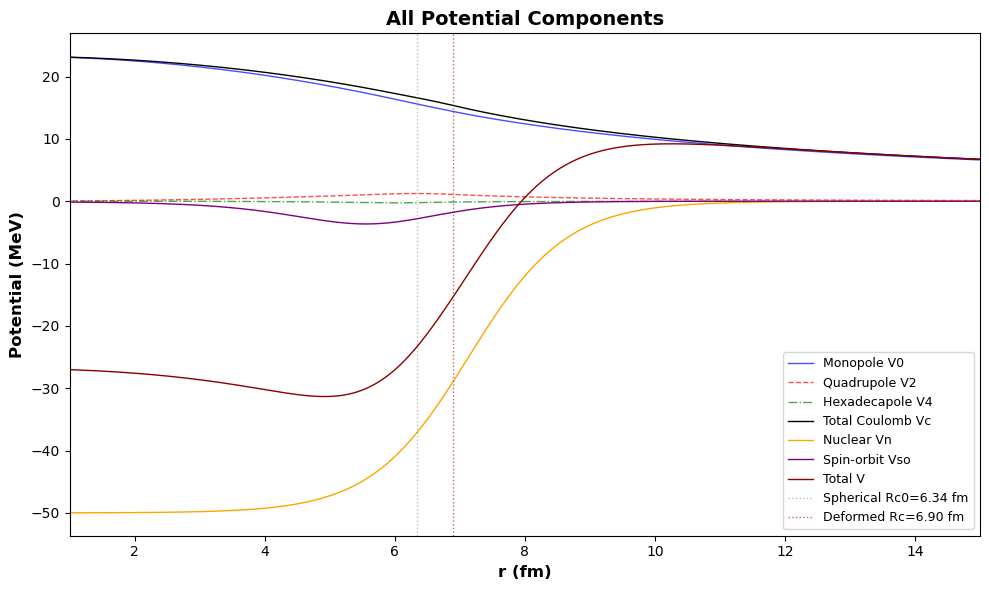

In [93]:
# ================== 计算势能 ==================

Vc_tot, V_0, V_2, V_4 = Vc_vectorized(z1, z2, r, theta_0, Rc0, beta2, beta4)

VVn = Vn(V0, r0, a0, beta2, beta4, beta2tilde, beta4tilde, r, theta_0)

VVso = Vso(Vso0, rso, aso, L, S, J, r, theta_0, beta2, beta4, beta2tilde, beta4tilde)

V_total = Vc_tot + VVn + VVso

# ================== 绘制图形 ==================
plt.figure(figsize=(10, 6))


plt.plot(r, V_0, 'b-', linewidth=1, alpha=0.7, label='Monopole V0')
plt.plot(r, V_2, 'r--', linewidth=1, alpha=0.7, label='Quadrupole V2')
plt.plot(r, V_4, 'g-.', linewidth=1, alpha=0.7, label='Hexadecapole V4')
plt.plot(r, Vc_tot, 'k-', linewidth=1, label='Total Coulomb Vc')
plt.plot(r, VVn, 'orange', linewidth=1, label='Nuclear Vn')
plt.plot(r, VVso, 'purple', linewidth=1, label='Spin-orbit Vso')
plt.plot(r, V_total, 'darkred', linewidth=1, label='Total V')

# 标记变形半径
Y20_0 = sph_harm_y(2, 0, theta_0, 0).real
Y40_0 = sph_harm_y(4, 0, theta_0, 0).real
Rc_deformed = Rc0 * (1 + beta2 * Y20_0 + beta4 * Y40_0)
plt.axvline(x=Rc0, color='gray', linestyle=':', alpha=0.5, linewidth=1, label=f'Spherical Rc0={Rc0:.2f} fm')
plt.axvline(x=Rc_deformed, color='brown', linestyle=':', alpha=0.7, linewidth=1, label=f'Deformed Rc={Rc_deformed:.2f} fm')

plt.xlabel('r (fm)', fontsize=12, fontweight='bold')
plt.ylabel('Potential (MeV)', fontsize=12, fontweight='bold')
plt.title('All Potential Components', fontsize=14, fontweight='bold')
plt.legend(fontsize=9, loc='lower right')
plt.xlim(1, 15)
plt.tight_layout()
plt.savefig('all_potential_components.pdf')
plt.show()

/Users/bojizheng/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/bojizheng/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


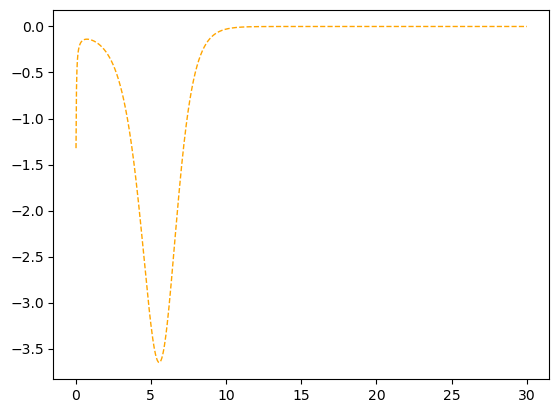

In [94]:
plt.plot(r, VVso, label='Spin-orbit Vso', color='orange', linewidth=1, linestyle='--')
plt.show()